In [5]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
# Ruta del archivo
file_path = "/content/drive/My Drive/Tesis/DATASET/data_pro.csv"
# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path)
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134147 entries, 0 to 134146
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Fecha                                 134147 non-null  object 
 1   Provincia                             134147 non-null  int64  
 2   Canton                                134147 non-null  int64  
 3   Empresa                               134147 non-null  int64  
 4   Grupo Consumo                         134147 non-null  int64  
 5   Numero Clientes                       134147 non-null  float64
 6   Energia Facturada (kWh)               134147 non-null  float64
 7   Facturacion Servicio Electrico (USD)  134147 non-null  float64
 8   Año                                   134147 non-null  int64  
 9   Mes                                   134147 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory 

In [7]:
data = df[['Fecha', 'Energia Facturada (kWh)', 'Empresa', 'Grupo Consumo', 'Numero Clientes']]

# Codificación de las variables categóricas
data['Empresa'] = data['Empresa'].astype('category').cat.codes
data['Grupo Consumo'] = data['Grupo Consumo'].astype('category').cat.codes

# Normalización con MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(
    data[['Energia Facturada (kWh)','Numero Clientes']]
)

scaled_data = pd.DataFrame(
    scaled_features,
    columns=['Energia Facturada', 'Numero Clientes']
)
scaled_data['Fecha'] = data['Fecha'].values


<ipython-input-7-137d8a935ad4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Empresa'] = data['Empresa'].astype('category').cat.codes
<ipython-input-7-137d8a935ad4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Grupo Consumo'] = data['Grupo Consumo'].astype('category').cat.codes


In [8]:
# Función para crear ventanas temporales
def create_dataset(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(data[i + time_steps, 0])  # Objetivo: Energia Facturada
    return np.array(X), np.array(y)

# Configuración de ventanas temporales
time_steps = 24
X, y = create_dataset(scaled_features, time_steps)

# Ajustar dimensiones para el modelo LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# División de los datos en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [9]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Callbacks para ajustar el learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler],
                    verbose=2)

# Predicciones del modelo
y_pred = model.predict(X_test)

Epoch 1/50
3354/3354 - 165s - 49ms/step - loss: 0.0077 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 2/50
3354/3354 - 189s - 56ms/step - loss: 0.0067 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 3/50
3354/3354 - 202s - 60ms/step - loss: 0.0062 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 4/50
3354/3354 - 211s - 63ms/step - loss: 0.0059 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 5/50
3354/3354 - 202s - 60ms/step - loss: 0.0057 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 6/50
3354/3354 - 208s - 62ms/step - loss: 0.0055 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 7/50
3354/3354 - 147s - 44ms/step - loss: 0.0054 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 8/50
3354/3354 - 156s - 47ms/step - loss: 0.0053 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 9/50
3354/3354 - 202s - 60ms/step - loss: 0.0052 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 10/50
3354/3354 - 156s - 47ms/step - loss: 0.0051 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 11/50
3354/33

In [15]:
# Cálculo de métricas
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Coeficiente de determinación (R²): {r2}")

Error cuadrático medio (MSE): 0.00028367444858324063
Raíz del error cuadrático medio (RMSE): 0.016842637815474175
Error absoluto medio (MAE): 0.0037602490381846666
Coeficiente de determinación (R²): 0.8649911115374265


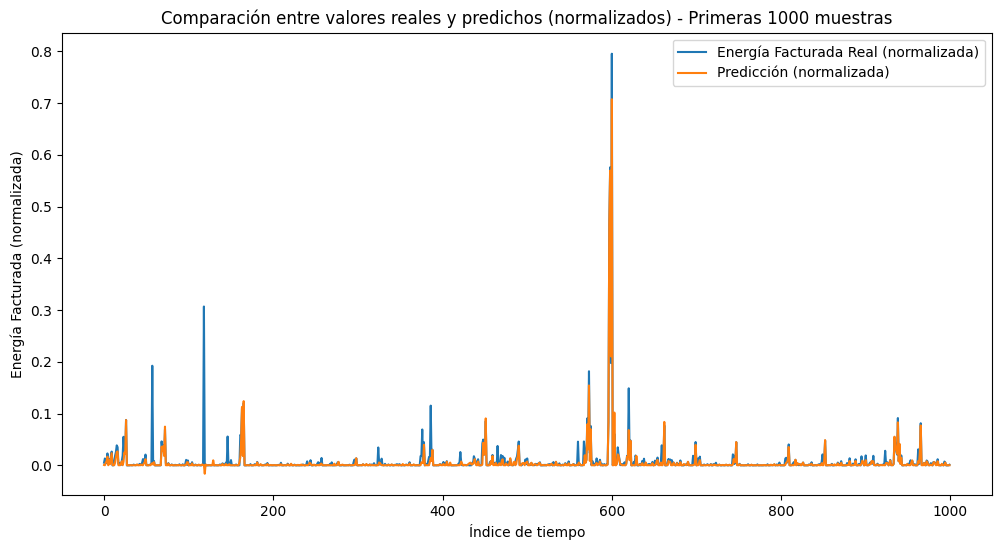

In [27]:
# Visualización de los resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='Energía Facturada Real (normalizada)')
plt.plot(y_pred[:1000], label='Predicción (normalizada)')
plt.legend()
plt.title('Comparación entre valores reales y predichos (normalizados) - Primeras 1000 muestras')
plt.xlabel('Índice de tiempo')
plt.ylabel('Energía Facturada (normalizada)')
plt.show()


In [13]:
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a datetime


<ipython-input-13-07ffbce9879c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a datetime


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,781 (1.36 MB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,188 (926.52 KB)

In [34]:
# Convertir 'Fecha' a datetime (si no está ya en ese formato)
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Extraer mes y día de la semana
data['Mes'] = data['Fecha'].dt.month  # Columna ya existe, pero se recalcula para asegurar consistencia
data['Dia_Semana'] = data['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo

# Seleccionar las 6 características (nombres exactos)
features = data[[
    'Energia Facturada (kWh)',
    'Numero Clientes',
    'Empresa',
    'Grupo Consumo',
    'Mes',
    'Dia_Semana'
]].values

<ipython-input-34-a5d8961778db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fecha'] = pd.to_datetime(data['Fecha'])
<ipython-input-34-a5d8961778db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mes'] = data['Fecha'].dt.month  # Columna ya existe, pero se recalcula para asegurar consistencia
<ipython-input-34-a5d8961778db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [35]:
print("Columnas disponibles en 'data':", data.columns.tolist())

Columnas disponibles en 'data': ['Fecha', 'Energia Facturada (kWh)', 'Empresa', 'Grupo Consumo', 'Numero Clientes', 'Mes', 'Dia_Semana']


In [37]:
# Crear secuencias con todas las características
X, y = create_dataset(features, time_steps=24)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Formato (muestras, 24, 6)

In [38]:
print("Forma de X:", X.shape)  # Debe ser (n_muestras, 24, 6)

Forma de X: (134123, 24, 6)


In [39]:
# Seleccionar las 6 características relevantes (incluyendo codificadas)
features = data[['Energia Facturada (kWh)', 'Numero Clientes', 'Empresa', 'Grupo Consumo', 'Mes', 'Dia_Semana']].values

# Crear secuencias con todas las características
X, y = create_dataset(features, time_steps=24)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Formato (muestras, 24, 6)

In [41]:
# Suponiendo que el scaler se ajustó solo a 'Energia Facturada (kWh)'
energy_scaler = MinMaxScaler().fit(data[['Energia Facturada (kWh)']])

# Desnormalizar predicciones y valores reales
y_test_real = energy_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = energy_scaler.inverse_transform(y_pred).flatten()

In [42]:
# Obtener fechas del conjunto de prueba
test_dates = data['Fecha'].iloc[-len(y_test):].values  # Asumiendo división cronológica

# Filtrar últimos 2 años (24 meses)
last_two_years_mask = (pd.to_datetime(test_dates) >= pd.to_datetime(test_dates[-1]) - pd.DateOffset(years=2))
y_test_filtered = y_test_real[last_two_years_mask]
y_pred_filtered = y_pred_real[last_two_years_mask]
dates_filtered = test_dates[last_two_years_mask]

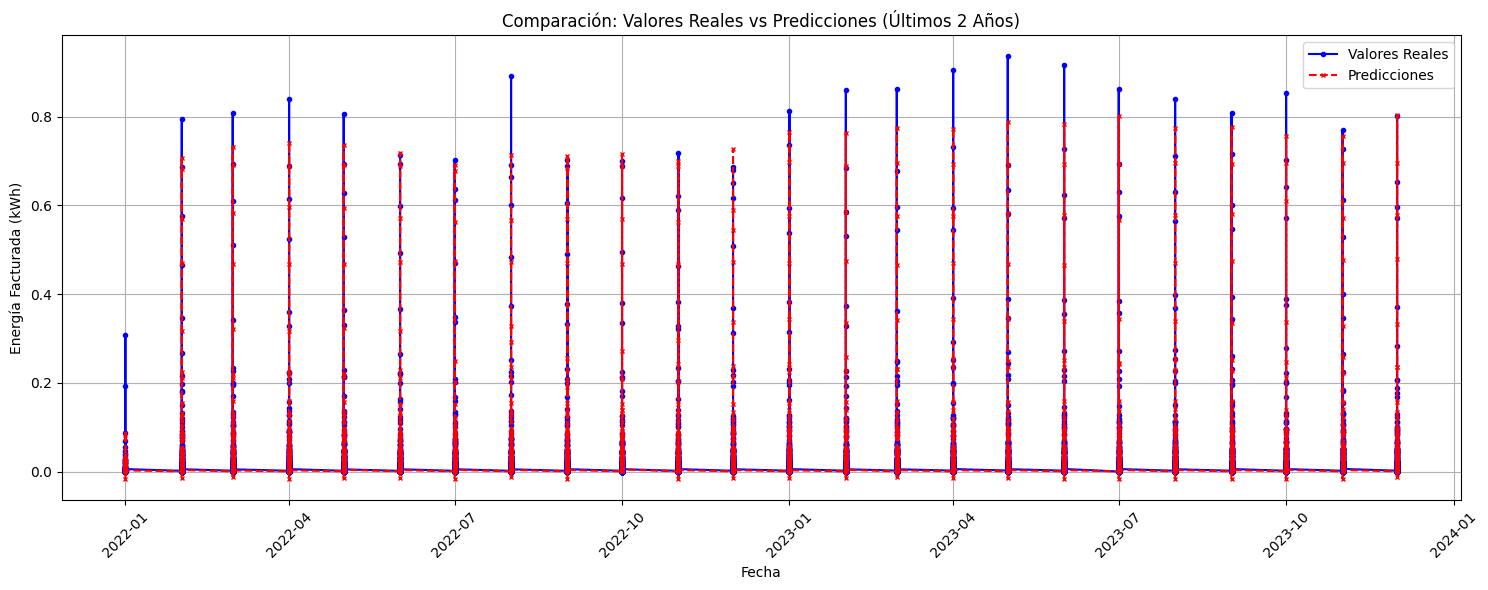

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(dates_filtered, y_test_filtered, label='Valores Reales', color='blue', marker='o', markersize=3)
plt.plot(dates_filtered, y_pred_filtered, label='Predicciones', color='red', linestyle='--', marker='x', markersize=3)
plt.title('Comparación: Valores Reales vs Predicciones (Últimos 2 Años)')
plt.xlabel('Fecha')
plt.ylabel('Energía Facturada (kWh)')
plt.legend()
plt.grid(True)

# Formatear fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()